<a href="https://colab.research.google.com/github/RGologorsky/fastmri/blob/master/05_kspace_classifier_real_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classifying real images in kspace

- Can a CNN learn to classify given kspace as input?
- Can we apply audio (time freq) techniques to kspace (spacial freq)?
  - MELGAN, MEL Spectogram, MFCC (http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)
  - Audio data augs

- Do max pooling layers help?

MRI scans have correct orientation; max pooling loses spacial info "ignores the relation between the part and the whole"
-- maybe try CNNs without max pooling?

![Max pooling, same features](https://miro.medium.com/max/1400/1*wsf4tsOH77T1lpylPUIhbA.png)

## Setup

In [1]:
PROJ       = "fastmri"

# clone repo
!git clone https://github.com/RGologorsky/fastmri.git

# pip install/import
%run "$PROJ/common_constants_env.ipynb" # pip install fastai, fastmri, etc
%run "$PROJ/common_archs.ipynb"         # get simple cnn (stride 2 all the way)
%run "$PROJ/01_kspace_tfms.ipynb"       # get the kspace tfms

Cloning into 'fastmri'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (260/260), done.
remote: Compressing objects: 100% (221/221), done.
remote: Total 260 (delta 86), reused 149 (delta 34), pack-reused 0
Receiving objects: 100% (260/260), 15.55 MiB | 17.72 MiB/s, done.
Resolving deltas: 100% (86/86), done.
pip install fastai2
git clone fastMRI
pip install ISMRMRD
pip install fasMRI req
sys append /content/fastMRI
imports


# Save/Export

Set export path (save model arch + weights)

1. Save in cloned github folder: `save_local = True`
2. Save in gdrive folder: `save_local = False`

Remember to PUSH after saving!

In [38]:
save_local = False

from google.colab import drive # import drive from google colab
from pathlib import Path

if save_local: EXPORT_DIR = f"{PROJ}/models"
else: 
  # Mount Google Drive 
  ROOT = "/content/drive"     # default location for the drive
  drive.mount(ROOT)           # mount google drive at /content/drive

  # set folder path in gdrive
  EXPORT_DIR = Path(ROOT)/"My Drive/fastai_proj"/PROJ/"models"
  EXPORT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Save to {EXPORT_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Save to /content/drive/My Drive/fastai_proj/fastmri/models


In [0]:
drive.mount??

## Data

MNIST instead of Imagenet because MNIST, like MRI scans, have correct orientation.

In [3]:
url = URLs.MNIST # sizes = 28x28

# download & unpack data in url
path = untar_data(url)
fnames = get_image_files(path)

### Test tfms on data

Selected fnames slice from 68807 to 68817
Batch of images: tensor of shape torch.Size([10, 28, 28])
Batch in kspace: tensor of shape torch.Size([10, 28, 28, 2])
Batch kspace2img: tensor of shape torch.Size([10, 28, 28])
Batch log abs kspace: tensor of shape torch.Size([10, 28, 28])


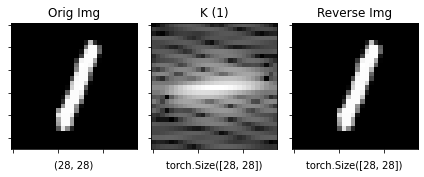

In [4]:
# select random slice of fnames
rand_idx = np.random.randint(0, len(fnames)-10)
bslice = slice(rand_idx,rand_idx+10)
print(f"Selected fnames slice from {rand_idx} to {rand_idx + 10}")

# get batch of images/labels
xb = [PILImageBW.create(fn) for fn in fnames[bslice]]
yb = [parent_label(fn) for fn in fnames[bslice]]

# im2tensor
t_xb = torch.stack(tuple(apply(x, TensorTfms.im2arr) for x in xb), dim=0)
print(f"Batch of images: tensor of shape {t_xb.shape}")

# im2kspace
k_xb = apply(t_xb, TensorTfms.real2k(onesided=False))
print(f"Batch in kspace: tensor of shape {k_xb.shape}")

# decodes
rev_xb = apply(k_xb, TensorTfms.k2real(onesided=False))
print(f"Batch kspace2img: tensor of shape {rev_xb.shape}")

# kspace abs
k_abs_xb = apply(k_xb, TensorTfms.log_abs, pre=TensorTfms.t_abs)
print(f"Batch log abs kspace: tensor of shape {k_abs_xb.shape}")

# plot an item in xb
i = 1
plot([xb[i], k_abs_xb[i], rev_xb[i]], [f"Orig Img", f"K ({yb[i]})", f"Reverse Img"])

# Dataset

Audio Data augs? Normalize?


In [0]:
raw_items = fnames

x_tfms = [PILImageBW.create]
y_tfms = [parent_label, Categorize]

splitter  = GrandparentSplitter(train_name = "training", valid_name = "testing")
splits = splitter(raw_items)

#splitter = GrandparentSplitter(valid_name="val")
#splittter = RandomSplitter(valid_pct=0.2, seed=42)

dsets = Datasets(raw_items, tfms = [x_tfms, y_tfms], splits=splits)

((#10) ['0','1','2','3','4','5','6','7','8','9'],
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc41f03a128>)

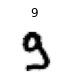

In [6]:
dsets.vocab, dsets.show(dsets[50000])

# Dataloaders

Define parameters

In [0]:
bs = 512
num_workers = 1

Define dataloaders (learning in image space)

In [0]:
# define size of ims after item/batching (to use in defining cnn)
item_sz, batch_sz = 28,28

item_tfms  = [ToTensor]
batch_tfms = [IntToFloatTensor] # Normalize? SaveShape

im_dls = dsets.dataloaders(
          after_item  = item_tfms, 
          after_batch = batch_tfms, 
          bs=bs, 
          num_workers = num_workers).cuda()

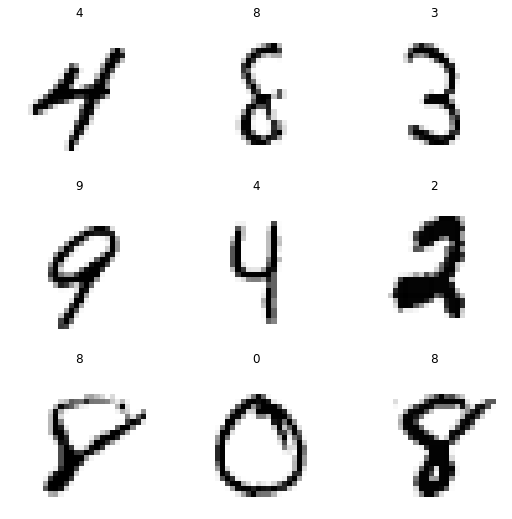

In [9]:
# viz
im_dls.show_batch()

Define dataloaders (learning in complex kspace)

In [0]:
# define size of ims after item/batching (to use in defining cnn)
item_sz, batch_sz = 28,28

k_item_tfms  = [ToTensor]
k_batch_tfms = [IntToFloatTensor, BatchReal2ComplexK, Complex2Channel] # Normalize? SaveShape

k_dls = dsets.dataloaders(
          after_item  = k_item_tfms, 
          after_batch = k_batch_tfms, 
          bs=bs, 
          num_workers = num_workers).cuda()

Batch kspace2img: tensor of shape torch.Size([512, 28, 28])
Batch log abs kspace: tensor of shape torch.Size([512, 28, 28])


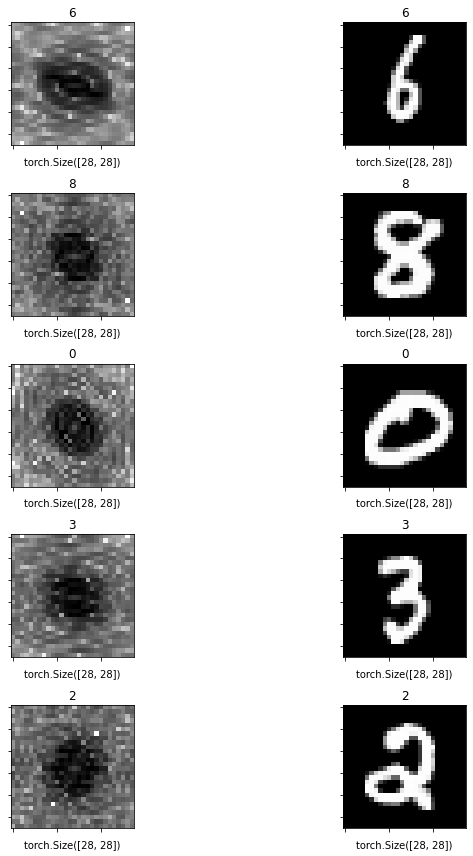

In [11]:
# viz

# get batch
k_xb, yb = k_dls.one_batch()
k_xb, yb = to_cpu(k_xb), to_cpu(yb)

# decodes
rev_k_xb = apply(Complex2Channel().decodes(k_xb), TensorTfms.batch_k2real(onesided=False))
print(f"Batch kspace2img: tensor of shape {rev_k_xb.shape}")

# kspace abs
abs_k_xb = apply(Complex2Channel().decodes(k_xb), TensorTfms.log_abs, pre=TensorTfms.t_abs)
print(f"Batch log abs kspace: tensor of shape {abs_k_xb.shape}")

# plot item in batch

# select slice
nb = 5
bslice = slice(0,nb)

# set titles/order of images to plot
titles = [x for i in range(nb) for x in [f"{yb[i]}",  f"{yb[i]}"]]
imgs   = [x for i in range(nb) for x in [abs_k_xb[i], rev_k_xb[i]]]

# plot
plot(imgs, titles, nrows=nb, ncols=2, figsize=(12,12))

Define dataloaders (learning in log amp kspace)

In [0]:
# define size of ims after item/batching (to use in defining cnn)
item_sz, batch_sz = 28,28

k_abs_item_tfms  = [ToTensor]
k_abs_batch_tfms = [IntToFloatTensor, BatchReal2ComplexK, ComplexK2LogAbs] # Normalize? SaveShape

k_abs_dls = dsets.dataloaders(
          after_item  = k_abs_item_tfms, 
          after_batch = k_abs_batch_tfms, 
          bs=bs, 
          num_workers = num_workers).cuda()

## print in a row

Batch of 10 digits in kspace (5 examples of each digit):
 tensor of shape torch.Size([50, 2, 28, 28])
Batch img (kspace to img): tensor of shape torch.Size([50, 28, 28])
Batch log abs kspace: tensor of shape torch.Size([50, 28, 28])


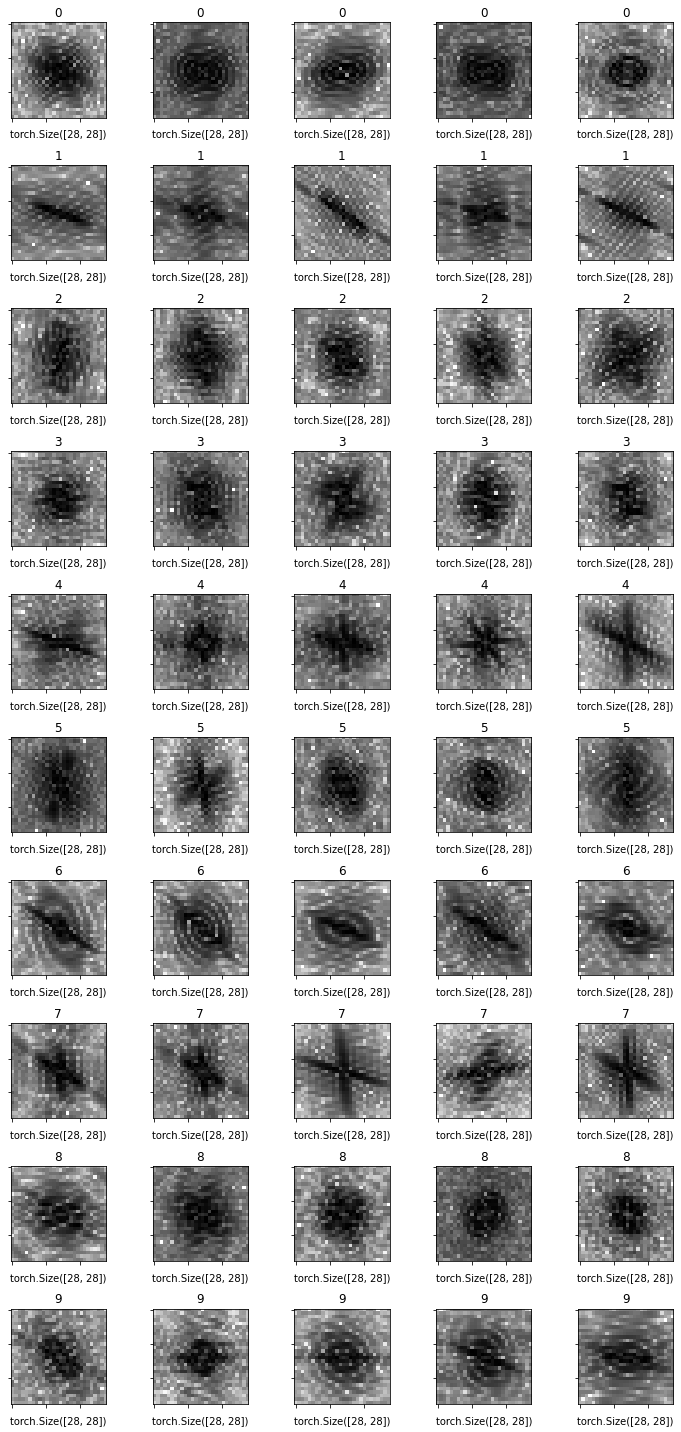

In [13]:
# set number of examples per row
ncols, nrows = 5, 10

# get random batch (512 bs)
kxb, yb = k_dls.one_batch()
kxb, yb = to_cpu(kxb), to_cpu(yb)

# grab 5 examples of each digit/category
kxbd = torch.cat(tuple(kxb[yb==digit][:ncols] for digit in range(10)), dim = 0)
ybd  = torch.cat(tuple(yb[yb==digit][:ncols] for digit in range(10)), dim = 0)
print(f"Batch of 10 digits in kspace ({ncols} examples of each digit):\n tensor of shape {kxbd.shape}")

# decodes
rev_kxbd = apply(Complex2Channel().decodes(kxbd), TensorTfms.batch_k2real(onesided=False))
print(f"Batch img (kspace to img): tensor of shape {rev_kxbd.shape}")

# kspace abs
abs_kxbd = apply(Complex2Channel().decodes(kxbd), TensorTfms.log_abs, pre=TensorTfms.t_abs)
print(f"Batch log abs kspace: tensor of shape {abs_kxbd.shape}")

# plot item in batch

# set titles/order of images to plot
titles = [f"{ybd[i]}" for i in range(ncols*nrows)]
imgs   = [abs_kxbd[i] for i in range(ncols*nrows)]

# plot
plot(imgs, titles, nrows=nrows, ncols=ncols, figsize=(10,20))

Digit 9 batch: torch.Size([59, 2, 28, 28]), torch.Size([59])
Indices of 9 in batch: [ 6 16 22 23 25 26 39 63 86 95]
Batch kspace2img: tensor of shape torch.Size([59, 28, 28])
Batch log abs kspace: tensor of shape torch.Size([59, 28, 28])


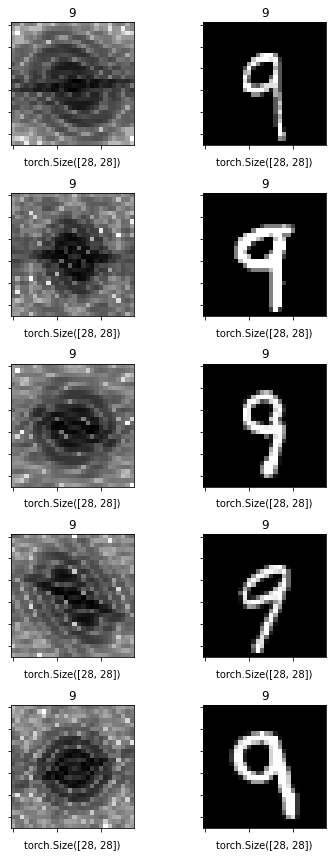

In [14]:
# screen for a particular digit

# get random batch (512 bs)
kxb, yb = k_dls.one_batch()
kxb, yb = to_cpu(kxb), to_cpu(yb)

# screen for digit
digit = 9

# x's,y's corresponding to digit 
kxbd = kxb[yb==digit] if digit != -1 else kxb
ybd  =  yb[yb==digit] if digit != -1 else kxb
print(f"Digit {digit} batch: {kxbd.shape}, {ybd.shape}")

# see idxs corresponding to digits
idxs = np.array(range(0, bs))[yb==digit]
print(f"Indices of {digit} in batch: {idxs[:10]}")

# decodes
rev_kxbd = apply(Complex2Channel().decodes(kxbd), TensorTfms.batch_k2real(onesided=False))
print(f"Batch kspace2img: tensor of shape {rev_kxbd.shape}")

# kspace abs
abs_kxbd = apply(Complex2Channel().decodes(kxbd), TensorTfms.log_abs, pre=TensorTfms.t_abs)
print(f"Batch log abs kspace: tensor of shape {abs_kxbd.shape}")

# plot item in batch

# select slice
nb = 5
bslice = slice(0,nb)

# set titles/order of images to plot
titles = [x for i in range(nb) for x in [f"{ybd[i]}",  f"{ybd[i]}"]]
imgs   = [x for i in range(nb) for x in [abs_kxbd[i], rev_kxbd[i]]]

# plot
plot(imgs, titles, nrows=nb, ncols=2, figsize=(6,12))

## Mean & STD 

(sparse k space though)

In [15]:
xb,yb = k_dls.one_batch()
xb,yb = to_cpu(xb), to_cpu(yb)
xb.shape, yb.shape

(torch.Size([512, 2, 28, 28]), torch.Size([512]))

Most of kspace has 0 amplitude/phase (sparse) -- not normally distributed

In [16]:
xb.mean(dim=[0,2,3]),xb.std(dim=[0,2,3])

(TensorImageBW([-1.3109e-13,  1.8422e-12]), TensorImageBW([0.1643, 0.2909]))

## kspace2polar

perhaps easier for linear conv to pick up on important patterns

From SO: OpenCV 3.4 can do this now pretty easily with warpPolar()

In [0]:
def convert_to_polar():
  pass

# Architecture

Arch -- wave2letter Audio spectogram arch

CNN - Simple, no max pooling. Conv consists of 2dconv + batchnorm + activation ReLU.

CNN - Simple, no max pooling, stride 2 conv layers until 1x1, then flatten. 

Conv layer consists of 2dconv + batchnorm + activation ReLU.

In [0]:
# greyscale-1 input channel, complex kspace-2 input channels

# cnns
simple_cnn   = get_simple_cnn(c_in=1, n_out=10, sz=batch_sz) 
k_simple_cnn = get_simple_cnn(c_in=2, n_out=10, sz=batch_sz)

# resnets
base_resnet = xresnet34
k_resnet   = base_resnet(c_in=2, n_out=10)
resnet     = base_resnet(c_in=1, n_out=10)

Test arch works

In [19]:
# all arch/dls
test_archs = [simple_cnn, resnet, k_simple_cnn, k_resnet]
test_dls   = [im_dls, k_dls, k_abs_dls]

# set arch/dl pair to test
arch_idx,dl_idx = 0,2

# test learning with given arch on given dls
arch,dls = test_archs[arch_idx].cpu(), test_dls[dl_idx]
xb,yb = dls.one_batch()
xb,yb = to_cpu(xb), to_cpu(yb)
output = arch(xb)
print(f"input:  {xb.shape}\noutput: {output.shape},\npreds: {output[0]}")

input:  torch.Size([512, 1, 28, 28])
output: torch.Size([512, 10]),
preds: tensor([ 0.8137,  2.7700,  1.6600, -0.9889, -0.6524,  0.9223,  2.2316,  0.7005,
         0.5948, -1.0560], grad_fn=<SelectBackward>)


# Learn

In [0]:
from fastai2.callback.hook import *

# set callbacks
cbs = [] #ActivationStats(with_hist=True)

# get learner w/given arch + dls + loss_func
def get_learner(dls, arch, loss_func = F.cross_entropy):
  return Learner(dls, arch.cuda(), loss_func, metrics=accuracy, cbs=cbs)

# Define learners

# learn in image space
learn_cnn    = get_learner(im_dls, simple_cnn)
learn_resnet = get_learner(im_dls, resnet)

# learn in k space
k_learn_cnn    = get_learner(k_dls, k_simple_cnn)
k_learn_resnet = get_learner(k_dls, k_resnet)

# learn in k_log_abs space (one-channel input so simple_cnn & resnet)
k_abs_learn_cnn    = get_learner(k_abs_dls, simple_cnn)
k_abs_learn_resnet = get_learner(k_abs_dls, resnet)

# learn.summary()

# EXPORT
# save model's trained weights
def export(learn, name, id): 
  learn.export(f"{EXPORT_DIR}/{name}-{id}-export.pkl")

def load(name, id, cpu=False):
  return load_learner(f"{EXPORT_DIR}/{name}-{id}-export.pkl", cpu=cpu)

# Train

Baseline random: predict 1 out of 10 classes, expect 10% accuracy from random predictions.

Outcomes:

| Space     | Learner            | Accuracy | Time per Epoch | LR     | n_epoch | momentum | arch      |
|-----------|--------------------|----------|----------------|--------|---------|----------|-----------|
| image     | learn_cnn          | 93.74%   |                | 0.6    | 1       | 1cycle   | simple_cnn |
| image     | learn_resnet       | 97.89%   |                | 1.5e-2 | 1       | 1cycle   | xresnet18 |
| complex k | k_learn_cnn        | 92.05%   | 51sec          | 0.33   | 1       | 1cycle   | simple_cnn |
| complex k | k_learn_resnet     | 96.25%   | 55sec          | 5.3e-3 | 1       | 1cycle   | xresnet18 |
| log abs k | k_abs_learn_cnn    | 63.71%   | 52sec          | 0.33   | 1       | 1cycle   | simple_cnn |
| log abs k | k_abs_learn_resnet | 73.87%   | 1min 59sec     | 0.03   | 1       | 1cycle   | xresnet18 |



- learn_cnn: learn.fit_one_cycle(n_epoch=1, lr=0.6), accuracy 93.74%
- learn_resnet: learn.fit_one_cycle(n_epoch=1, lr=1.5e-2), accuracy 97.89%

- k_learn_cnn, learn.fit_one_cycle(n_epoch=1, lr=0.33), accuracy 92.05% - time per epoch: 51sec
- k_learn_resnet, learn.fit_one_cycle(n_epoch=1, lr=5.3e-3), accuracy 96.25% - time per epoch: 55sec

- k_abs_learn_cnn, learn.fit_one_cycle(n_epoch=1, lr=0.33), accuracy 63.71% - time per epoch: 52sec
- k_abs_learn_resnet, learn.fit_one_cycle(n_epoch=1, lr=0.03), accuracy 73.87% - time per epoch: 1min 59sec

## im space cnn

In [0]:
# # to load from saved version:
# learn = load("mnist_learn_cnn_no_aug", "epoch-5")
# learn.dls=learn_cnn.dls

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0012022644514217973)

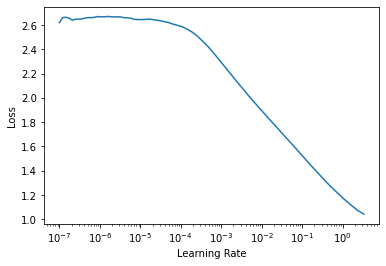

In [25]:
learn = learn_cnn
learn.lr_find()

# learn.summary()

In [26]:
learn_cnn.summary()

Sequential (Input shape: ['512 x 1 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               512 x 8 x 14 x 14    208        True      
________________________________________________________________
BatchNorm2d          512 x 8 x 14 x 14    16         True      
________________________________________________________________
ReLU                 512 x 8 x 14 x 14    0          False     
________________________________________________________________
Conv2d               512 x 16 x 7 x 7     1,168      True      
________________________________________________________________
BatchNorm2d          512 x 16 x 7 x 7     32         True      
________________________________________________________________
ReLU                 512 x 16 x 7 x 7     0          False     
________________________________________________________________
Conv2d               512 x 32 x 4 x 4     4,640      True      
__________________________________________________

In [27]:
learn.fit_one_cycle(n_epoch=1, lr=0.6)

epoch,train_loss,valid_loss,accuracy,time
0,0.695709,0.543602,0.934600,01:17


In [0]:
export(learn, "mnist_learn_cnn_no_aug", "epoch-1")

## im sp resnet

In [0]:
learn = learn_resnet
learn.lr_find()

In [0]:
learn.fit_one_cycle(n_epoch=1, lr=2e-3)

In [0]:
export(learn, "mnist_learn_resnet_no_aug", "epoch5")

## kspace cnn

In [0]:
learn = k_learn_cnn
learn.lr_find()

In [0]:
learn.fit_one_cycle(n_epoch=1, lr=0.27)

In [0]:
export(learn, "mnist_k_learn_cnn_no_aug", "epoch5")

## kspace resnet

In [0]:
learn = k_learn_resnet
learn.lr_find()

In [0]:
learn.fit_one_cycle(n_epoch=1, lr=2e-3)

In [0]:
export(learn, "mnist_k_learn_resnet", "epoch5")

## kspace abs cnn

In [0]:
learn = k_abs_learn_cnn
learn.lr_find()

In [0]:
learn.fit_one_cycle(n_epoch=1, lr=0.23)

In [0]:
export(learn, "mnist_k_abs_learn_cnn_no_aug", "epoch5")

## kspace abs resnet

In [0]:
learn = k_abs_learn_resnet
learn.lr_find()

In [0]:
learn.fit_one_cycle(n_epoch=1, lr=2e-3)

In [0]:
export(learn, "mnist_k_abs_learn_resnet_no_aug", "epoch5")

In [0]:
#learn.activation_stats.plot_layer_stats(-2)
#learn.activation_stats.plot_layer_stats(0)

# Push exported files :)


# Old

In [0]:
# for Imagenette data

# convert filename stem to category
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

y_tfms = [parent_label, lbl_dict.__getitem__, Categorize]


In [0]:
learn = k_learn_cnn
learn.lr_find()

In [0]:
learn.fit_one_cycle(n_epoch=1, lr=0.33)

In [0]:
learn.fit_one_cycle(n_epoch=1, lr=0.1)

In [0]:
#learn.activation_stats.plot_layer_stats(-2)
#learn.activation_stats.plot_layer_stats(0)

# Old

In [0]:
# for Imagenette data

# convert filename stem to category
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

y_tfms = [parent_label, lbl_dict.__getitem__, Categorize]


In [0]:
# save original shape to IRFFT can umambiguously decode
class SaveShape(Transform):
  order = 12

  # excluding batch dimension
  def save_shape(t:Tensor):
    t.set_meta({"orig_shape": t.shape[-2:]})
    return t

In [0]:
# take dataset item (real img, category), convert to (k arr, category)
class Real2ComplexKOneSided(Transform):
  order = 13 # needs to run after save shape

  def encodes(self, t:Tensor): return apply(t, TensorTfms.real2k)


  def decodes(self, t_k:Tensor):
    t_k_abs         = apply(t_k, TensorTfms.t_abs)
    t_k_log_abs     = apply(t_k_abs, TensorTfms.log_abs)

    orig_shape = t_k.get_meta("orig_shape")
    t_real     = apply(t_k, TensorTfms.k2real(s=orig_shape))
    
    return ShowK(t_k_log_abs, t_real)

In [0]:
# k tensor that knows how to show itself
class K():
  def __init__(self, k, orig_shape):
    self.k, self.orig_shape = k, orig_shape

  def show(self, ctx=None, **kwargs): 
    rev_img = apply(self.k, TensorTfms.k2real(self.orig_shape))
    show_image(rev_img, cmap = "gray", title = "IRFFT", ctx=ctx, **kwargs)

  def to_tensor(self): return self.k

In [0]:
# convert original img arr to k space
class KTfm(Transform):
  
  # store orig shape so it can be decoded correctly (for showing purposes)
  def encodes(self, arr)->Tensor:
    return K(apply(arr, TensorTfms.real2k), arr.shape)

In [0]:
# permute tensor: HW(Complex) to (Complex)HW
class Permute(Transform):
  order = 1
  def encodes(self, t:Tensor):
    if t.size(-1) == 2: return t.transpose(-1,-3).transpose(-1,-2)
    return t

  def decodes(self, t:Tensor):
    if t.size(-1) == 2: return t.transpose(-1,-2).transpose(-1,-3)
    return t

## Old Viz

In [0]:
def k_show_batch(xb, yb, samples=None, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    
    t_k = Complex2Channel().decodes(xb)

    t_k_abs         = apply(t_k, TensorTfms.t_abs)
    t_k_log_abs     = apply(t_k_abs, TensorTfms.log_abs)

    orig_shape = xb[0].get_meta("orig_shape") # assume all shapes in batch equal
    t_real     = apply(t_k, TensorTfms.batch_k2real(onesided=False))
    
    if nrows is None: nrows = max_n//ncols

    if figsize is None: figsize = (ncols*6, 2 * nrows * 3)

    if ctxs is None: ctxs = get_grid(2*max_n, nrows=2*nrows, ncols=ncols, figsize=figsize)
    
    for i,ctx in enumerate(ctxs):
      row, col = i//ncols, i % ncols

      # odd rows show img in k space, even rows show img in real space
      arr     = t_k_log_abs if row%2 else t_real
      arr_idx = (row//2) * ncols + col
      
      im      = arr[arr_idx]    
      y       = yb[arr_idx]

      cmap = "gray_r" if row%2 else "gray"

      ctx.imshow(im, cmap=cmap)
      ctx.set_xticklabels([]), ctx.set_yticklabels([])
      ctx.set_title(f"{y}")
      #ctx.set_xlabel(tuple(im.shape))

In [0]:
# shows real & kspace together
class ShowK(Tuple):

  def show(self, ctx=None, **kwargs): 
    k,real = self
    line = k.new_zeros(k.shape[0], 10)
    return show_image(torch.cat([k,line,real], dim=1), title = "K & Real", ctx=ctx, **kwargs)

In [0]:
xb,yb = dls.one_batch()

In [0]:
xb.shape

In [0]:
t_k = tensor(xb[0])
t_k.shape

In [0]:
t_k = Complex2Channel().decodes(t_k)
t_k.shape

In [0]:
show_k = Real2ComplexK().decodes(t_k)
type(show_k)

In [0]:
show_k.show(figsize=(6,6), cmap="gray_r")